On policy prediction with function approximation : Linear TD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

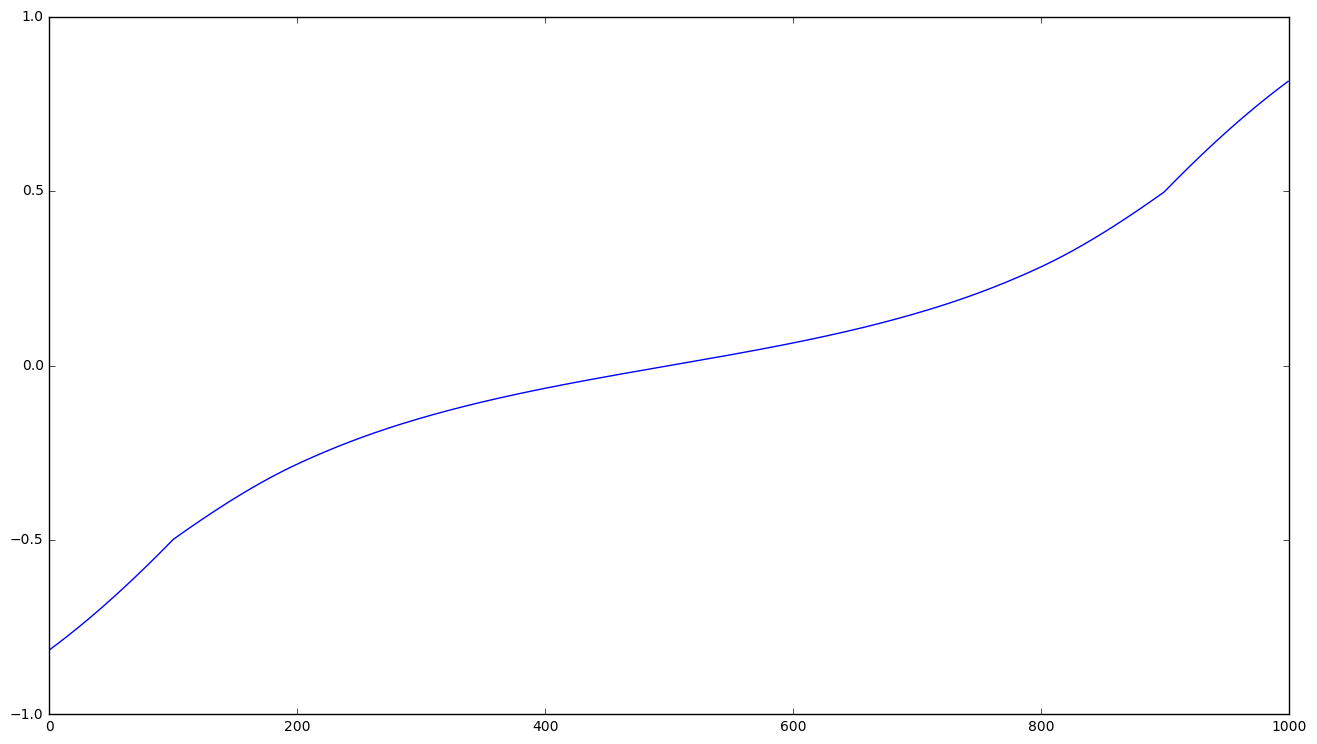

In [424]:
#discount factor
gamma=0.95


#define number of states
n=1000


#define starting state distribution
mu=np.random.rand(n)
mu=mu/np.sum(mu)

#define policy
#random walk, move +/- one at each step
P_pi = np.zeros((n+1,n+1))
nStep=100

for i in range(1,nStep+1):
    P_pi+=(1.0/(nStep*2.0)) * np.diag(np.ones(n+1-i),i)
    P_pi+=(1.0/(nStep*2.0)) * np.diag(np.ones(n+1-i),-i)

P_pi[0,:]=0
P_pi[:,0]=0
P_pi[0,0]=1

for i in range(0,nStep):
    P_pi[i+1,0]=0.5-(i)/(2.0*nStep)
    P_pi[n-i,0]=0.5-(i)/(2.0*nStep)

#print P_pi

#define reward vector
#reward of +1 when reach right end, -1 if reach left end
r_pi=np.zeros(n+1)
for i in range(0,nStep):
    r_pi[i+1]=-(0.5-(i)/(2.0*nStep))
    r_pi[n-i]=0.5-(i)/(2.0*nStep)
#print r_pi
    
#compute and plot true value function v_pi
plt.figure(figsize=(16,9))
v_pi = np.linalg.solve( (np.eye(n+1)-gamma*P_pi),r_pi)
plt.plot(v_pi[range(1,n+1)])
plt.show()
    
#number of aggregated states
k=20
#define Phi matrix
Phi=np.vstack((np.zeros(k),np.kron(np.eye(k),np.ones((n/k,1)))))
u=np.zeros(n+1).reshape((n+1,1))
u[0]=1
Phi=np.hstack((u,Phi))

In [425]:
#compute stationary distribution
P_pi[0,0]=0
P_pi[0,n/2]=1
[e,v]=np.linalg.eig(P_pi.T)
d_=np.abs(v[:,0])/np.sum(np.abs(v[:,0]))
D=np.diag(d_)
P_pi[0,0]=1
P_pi[0,n/2]=0

In [164]:
def MSVE(theta,D,Phi,v_pi):
    v_hat=Phi.dot(theta)
    return (v_hat-v_pi).T.dot(D).dot(v_hat-v_pi)

In [302]:
#Gradient MC Algorithm
nEp_mc=50000 #number of episodes
d_mc=np.zeros(n+1) #counts how many times each state is visited
alpha_mc=2*10**(-5)
MSVE_mc=np.zeros(nEp_mc)

#initialize weights
theta_mc=np.zeros(k+1)

print 0,'/',nEp_mc
for e in range(nEp_mc):
    if((e+1) % (nEp_mc/10) == 0):
        print e+1,'/',nEp_mc
    
    #generate an episode
    s=n/2
    u=[]
    while(s != 0):
        u.append(s)
        d_mc[s] +=1
        
        #make a move according to policy
        s_=np.random.choice(n+1,1,True,P_pi[s,:])[0]
        
        #observe reward
        #negative reward can only be obtained if s<=nStep
        r = (s_==0) * (1-2*(s<=nStep))
        
        #update state
        s=s_
    
    d_mc[0]+=1
    #compute reward
    G=r #-1 if s<0
    
    #apply MC backup
    for s in u:
        theta_mc = theta_mc + alpha_mc * (G-np.dot(theta_mc,Phi[s,:]))*(Phi[s,:])
    
    #compute approximated value function
    v_mc=np.dot(Phi,theta_mc)

    #compute MSVE
    MSVE_mc[e] = np.sum( (d_mc/np.sum(d_mc)) * np.square(v_mc-v_pi) )

#compute approximated value function
v_mc=np.dot(Phi,theta_mc)

0 / 50000
5000 / 50000
10000 / 50000
15000 / 50000
20000 / 50000
25000 / 50000
30000 / 50000
35000 / 50000
40000 / 50000
45000 / 50000
50000 / 50000


In [5]:
#semi-gradient TD(0)
nEp_td=50000 #number of episodes
alpha_td=0.01
d_td=np.zeros(n+1)
MSVE_td=np.zeros(nEp_td)

#initialize weights
theta_td=np.zeros(k+1)

print 0,'/',nEp_td
for e in range(nEp_td):
    
    if( (e+1) % (nEp_td/10) == 0):
        print e+1,'/',nEp_td
    
    #intialize state
    s=n/2
    #alpha_td=np.log(e+1)/(e+1)
    while(s !=0):
        #u.append(s)
        d_td[s] +=1
        
        #make a move according to policy
        s_=np.random.choice(n+1,1,True,P_pi[s,:])[0]
        
        #observe reward
        #negative reward can only be obtained if s<=nStep
        r = (s_==0) * (1-2*(s<=nStep))
        
        #perform TD(0) update
        theta_td = theta_td + alpha_td * (r+gamma*np.dot(theta_td,Phi[s_,:])-np.dot(theta_td,Phi[s,:]))*(Phi[s,:])
        
        #update state
        s=s_
        
    d_td[0]+=1
    
    #compute approximated value function
    v_td=np.dot(Phi,theta_td)

    #compute MSVE
    MSVE_td[e] = np.sum( (d_td/np.sum(d_td)) * np.square(v_td-v_pi) )
    

#compute value function for each state
v_td=np.dot(Phi,theta_td)

0 / 50000
5000 / 50000
10000 / 50000
15000 / 50000
20000 / 50000
25000 / 50000
30000 / 50000
35000 / 50000
40000 / 50000
45000 / 50000
50000 / 50000


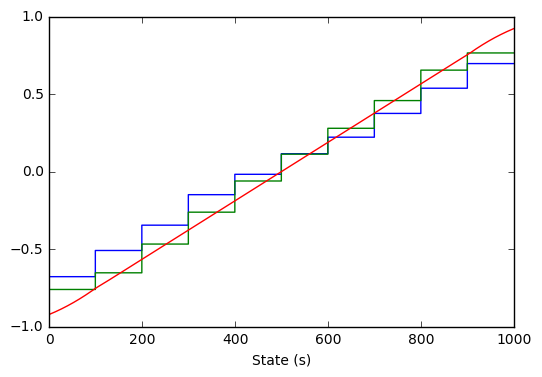

In [290]:
#plot results

plt.step(v_td[range(1,n+1)], 'b-')
plt.step(v_mc[range(1,n+1)], 'g--')
plt.plot(v_pi[range(1,n+1)], 'r-')
plt.xlabel('State (s)')

plt.show()

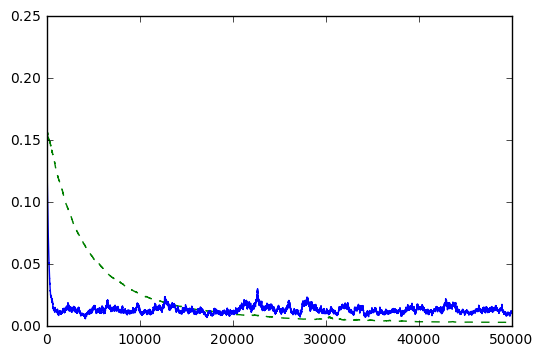

In [304]:
RMS_mc=np.sqrt(MSVE_mc)
RMS_td=np.sqrt(MSVE_td)

plt.plot(MSVE_mc,'g--')
plt.plot(MSVE_td,'b-')
plt.show()

In [306]:
print MSVE(theta_mc,D,Phi,v_pi)
print MSVE_mc[nEp_mc-1]

0.00330811969371
0.00330381392143


In [339]:
theta_td_star = np.linalg.inv(np.linalg.multi_dot((Phi.T,D,(np.eye(n+1)-gamma*P_pi),Phi))).dot(Phi.T).dot(D).dot(r_pi)
theta_mc_star = np.linalg.inv(np.linalg.multi_dot((Phi.T,D,Phi))).dot(Phi.T).dot(D).dot(v_pi)
#print np.max(np.abs(theta_td-theta_td_star))

plt.step(Phi.dot(theta_td)[range(1,n+1)],'b')
plt.step(Phi.dot(theta_td_star)[range(1,n+1)],'g')
plt.plot(v_pi,'r')
plt.show()

print np.max(np.abs(theta_mc-theta_mc_star))
plt.step(Phi.dot(theta_mc)[range(1,n+1)],'b')
plt.step(Phi.dot(theta_mc_star)[range(1,n+1)],'g')
plt.plot(v_pi,'r')
plt.show()

NameError: name 'theta_td' is not defined

In [340]:
mmc=MSVE(theta_mc_star,D,Phi,v_pi)
mtd=MSVE(theta_td_star,D,Phi,v_pi)
print mtd
print mmc

0.000369060549359
0.000342962829212


In [427]:
#compute theoretical MSVE for n-step TD methods
nbSteps=50
msve_n = np.zeros(nbSteps)
Theta=np.zeros((nbSteps,k+1))
P=gamma*P_pi
r=r_pi
M=np.eye(n+1,n+1)
for i in range(nbSteps):
    if((i+1)%(nbSteps/10)==0):
        print i+1,'/',nbSteps
    #compute MSVE for (i+1)-step TD method
    Q = np.linalg.inv(np.linalg.multi_dot((Phi.T,D,(np.eye(n+1)-P),Phi)))
    Theta[i,:] = np.linalg.multi_dot((Q,Phi.T,D,M,r))
    msve_n[i]=MSVE(Theta[i,:],D,Phi,v_pi)
    
    #update M and P
    #recall P=P_pi ^ n
    #and M=Sum_k gamma^k P_pi^k
    M=M+P
    P=gamma*P.dot(P_pi)

theta_mc_star = np.linalg.inv(np.linalg.multi_dot((Phi.T,D,Phi))).dot(Phi.T).dot(D).dot(v_pi)

mmc=MSVE(theta_mc_star,D,Phi,v_pi)
mtd=MSVE(theta_td_star,D,Phi,v_pi)

5 / 50
10 / 50
15 / 50
20 / 50
25 / 50
30 / 50
35 / 50
40 / 50
45 / 50
50 / 50


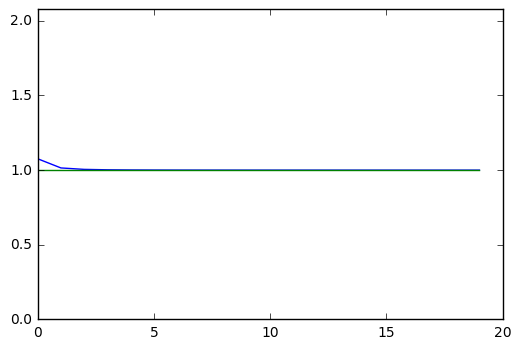

1.07609489404
1.01463020829


In [341]:
#plot normalized errors (ie MC error is 1)
plt.plot(msve_n[range(20)]/mmc)
plt.plot(np.ones(20))
#plt.plot(mmc*(1+np.power(gamma*np.ones(20),np.arange(20))))
plt.axis([0,20,0,np.max(msve_n[0]/mmc)+1])
plt.show()
print msve_n[0]/mmc
print msve_n[1]/mmc

In [428]:
v_td=(Phi.dot(Theta.T)).T
v_mc=(Phi.dot(theta_mc_star)).T
print v_td.shape
print v_mc.shape

(50L, 1001L)
(1001L,)


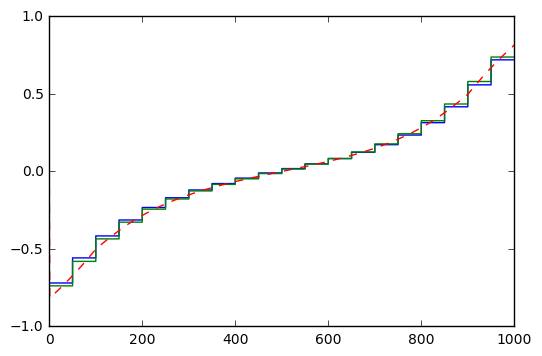

In [429]:
plt.step(v_td[0,:],'b')
plt.step(v_mc,'g')
plt.plot(v_pi,'r--')
plt.show()

In [472]:
from sklearn import decomposition

In [485]:
v_td.shape
pca=decomposition.PCA(n_components=2)
pca.fit(v_td)
print(pca.explained_variance_ratio_)

[ 0.99172997  0.00777506]


11.0034672668 -2.04017572054
10.9011251432 -1.99534610338


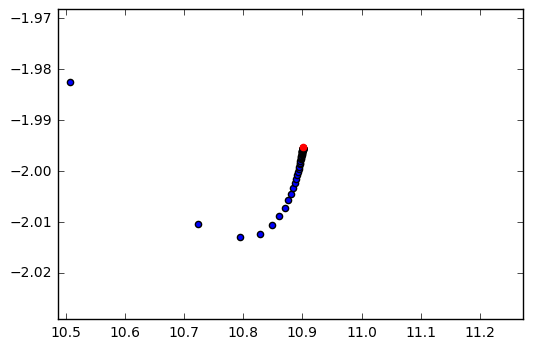

In [486]:
u_x=pca.components_[0,:] 
u_y=pca.components_[1,:] 
u_z = (v_pi-v_mc) / np.sqrt(((v_pi-v_mc).T.dot(D).dot((v_pi-v_mc))))

v_td_proj_x=u_x.dot((v_td).T)
v_td_proj_y=u_y.dot((v_td).T)
v_td_proj_z=u_z.dot(D).dot((v_td).T)

print u_x.dot(v_pi),u_y.dot(v_pi)
print u_x.dot(v_mc),u_y.dot(v_mc)

mean_x=np.mean(v_td_proj_x)
mean_y=np.mean(v_td_proj_y)
scale_x =  np.max(v_td_proj_x) - np.min(v_td_proj_x)
scale_y =  np.max(v_td_proj_y) - np.min(v_td_proj_y)

plt.scatter(v_td_proj_x,v_td_proj_y)
plt.scatter(u_x.dot(v_mc),u_y.dot(v_mc),color='r')
plt.scatter(u_x.dot(v_pi),u_y.dot(v_pi),color='g')

plt.axis([mean_x-scale_x,mean_x+scale_x,mean_y-scale_y,mean_y+scale_y])
plt.show()

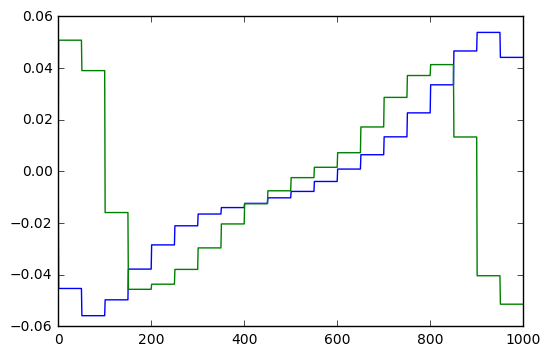

In [487]:
plt.plot(u_x)
plt.plot(u_y)
plt.show()

In [454]:
v_td[0,:].dot(D).dot(v_pi-v_mc)

5.2516042729766621e-20

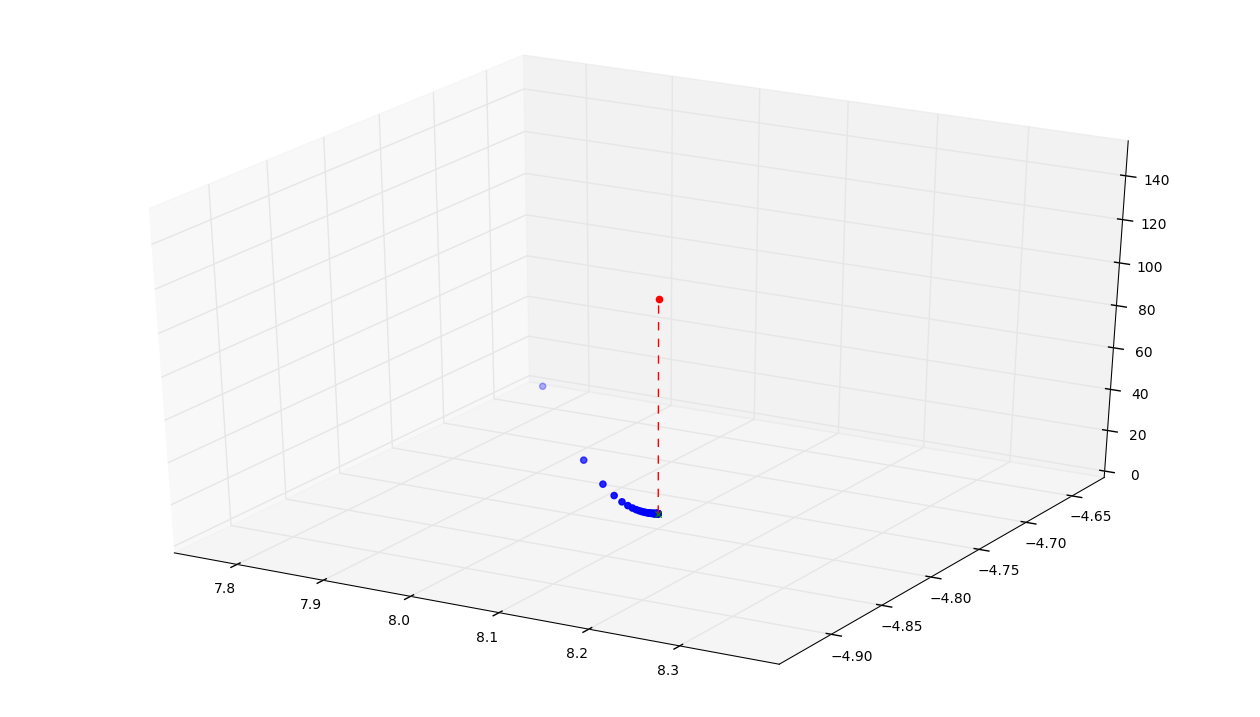

In [470]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(v_td_proj_x,v_td_proj_y,v_td_proj_z,color='b')
ax.scatter(u_x.dot(v_mc),u_y.dot(v_mc),0.0,color='g',marker='x')
ax.scatter(u_x.dot(v_pi),u_y.dot(v_pi),u_z.dot(v_pi),color='r')
ax.plot([u_x.dot(v_mc),u_x.dot(v_mc)],
        [u_y.dot(v_mc),u_y.dot(v_mc)],
        [0.0,u_z.dot(v_pi)],'r--')
ax.set_xlim([mean_x-scale_x,mean_x+scale_x])
ax.set_ylim([mean_y-scale_y,mean_y+scale_y])
ax.set_zlim([1.5*np.min([0,u_z.dot(v_pi)]),1.5*np.max([0,u_z.dot(v_pi)])])
plt.show()